### Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = sns.load_dataset('titanic')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [3]:
data.describe() # 기술 통계량 제공

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


age, embarked, deck, embarked_town에 결측치가 존재한다는 것을 알 수 있다.

#### Data Preprocessing

In [4]:
data['age'].fillna(data['age'].mean(), inplace = True)

In [5]:
data['embarked'].fillna(data['embarked'].mode()[0], inplace = True)

Text데이터로 되어있는 것들은 `LabelEncoder`를 이용해 인코딩을 해 준다

In [6]:
from sklearn.preprocessing import LabelEncoder

data['sex'] = LabelEncoder().fit_transform(data['sex'])

In [7]:
data['embarked'] = LabelEncoder().fit_transform(data['embarked'])

In [8]:
data['class'] = LabelEncoder().fit_transform(data['class'])
data['who'] = LabelEncoder().fit_transform(data['who'])

In [9]:
data.drop(['deck'], axis = 1, inplace = True)
data['adult_male'] = LabelEncoder().fit_transform(data['adult_male'])
data['embark_town'].fillna(data['embark_town'].mode()[0], inplace = True)
data['embark_town'] = LabelEncoder().fit_transform(data['embark_town'])
data['alive'] = LabelEncoder().fit_transform(data['alive'])
data['alone'] = LabelEncoder().fit_transform(data['alone'])

#### Multicollinearity

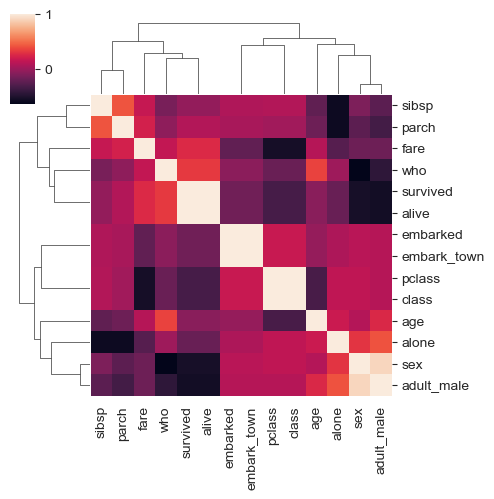

In [10]:
sns.clustermap(data.corr(), figsize = (5, 5))
plt.show()

pclass와 class, embark town과 embarked는 거의 동일한 변수이므로 둘 중 하나를 삭제하도록 한다

In [11]:
data.drop(['embark_town','pclass','alive'], axis = 1, inplace = True)

### data Split

In [12]:
from sklearn.model_selection import train_test_split

X = data.drop(['survived'], axis = 1)
y = data['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = 0.2
)

In [13]:
X_train.head()

,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alone
331,1,45.5,0,0,28.5000,2,0,1,1,1
733,1,23.0,0,0,13.0000,2,1,1,1,1
382,1,32.0,0,0,7.9250,2,2,1,1,1
704,1,26.0,1,0,7.8542,2,2,1,1,0
813,0,6.0,4,2,31.2750,2,2,0,0,0


### Modeling

#### Logit Model

In [17]:
import statsmodels.api as sm

logit = sm.Logit(
    y_train, 
    sm.add_constant(X_train)
).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.418576
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                           10
Date:                Sat, 08 Jun 2024   Pseudo R-squ.:                  0.3680
Time:                        23:42:05   Log-Likelihood:                -298.03
converged:                       True   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 1.701e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5915      0.618      5.813      0.000       2.381       4.803
sex            0.1367      0.

In [47]:
logit_prob = logit.predict(
        sm.add_constant(X_test)
    ).values.reshape(-1, 1)

In [48]:
from sklearn.metrics import accuracy_score
logit_pred = (
        logit_prob > 0.5
    ).astype(int)

In [49]:
print(f'Accuracy of Logit Model : {accuracy_score(y_test, logit_pred): .4f}')

Accuracy of Logit Model :  0.8156


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



In [51]:
confusion_matrix(y_test, logit_pred)

array([[91, 14],
       [19, 55]])

In [65]:
from sklearn.metrics import roc_curve, auc

fpr_logit, tpr_logit, thres = roc_curve(y_test, logit_prob)

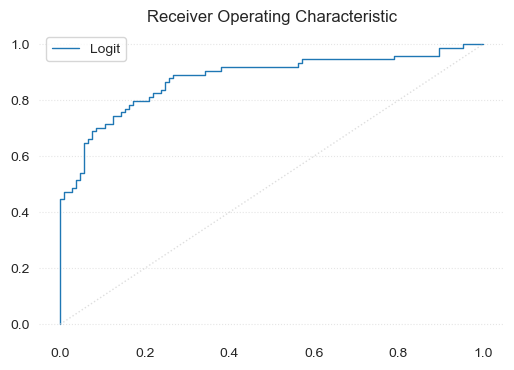

In [69]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_logit, tpr_logit, label = 'Logit', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Probit Model

In [71]:
probit = sm.Probit(
    y_train, 
    sm.add_constant(X_train)
).fit()
print(probit.summary())

Optimization terminated successfully.
         Current function value: 0.419226
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:               survived   No. Observations:                  712
Model:                         Probit   Df Residuals:                      701
Method:                           MLE   Df Model:                           10
Date:                Sun, 09 Jun 2024   Pseudo R-squ.:                  0.3670
Time:                        00:46:52   Log-Likelihood:                -298.49
converged:                       True   LL-Null:                       -471.54
Covariance Type:            nonrobust   LLR p-value:                 2.674e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0763      0.359      5.787      0.000       1.373       2.779
sex            0.0852      0.

In [72]:
probit_prob = probit.predict(
    sm.add_constant(X_test)
).values.reshape(-1, 1)

In [73]:
probit_pred = (probit_prob > 0.5).astype(int)

In [74]:
print(f'Accuracy of Probit Model : {accuracy_score(y_test, probit_pred): .4f}')

Accuracy of Probit Model :  0.8156


In [75]:
print(classification_report(y_test, probit_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



In [76]:
confusion_matrix(y_test, probit_pred)

array([[91, 14],
       [19, 55]])

In [78]:
fpr_probit, tpr_probit, thres = roc_curve(y_test, probit_prob)

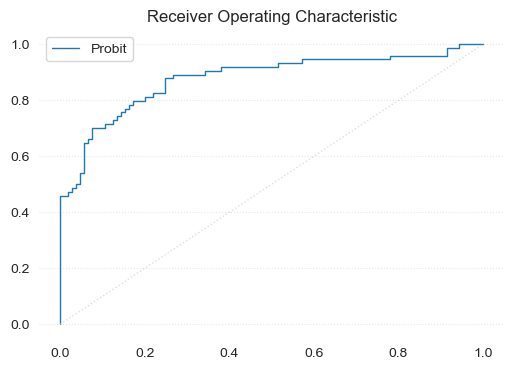

In [79]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_probit, tpr_probit, label = 'Probit', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Support Vector Machine

In [102]:
from sklearn.svm import SVC

support_vector = SVC(
    kernel = 'linear',
    C = 1,
    probability = True,
    random_state = 42
)
support_vector.fit(X_train, y_train)

SVC(C=1, kernel='linear', probability=True, random_state=42)

In [103]:
svm_pred = support_vector.predict(X_test)
print(f'Accuracy of Support Vector Model : {accuracy_score(y_test, svm_pred) : .4f}')

Accuracy of Support Vector Model :  0.8045


In [104]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



In [105]:
confusion_matrix(y_test, svm_pred)

array([[90, 15],
       [20, 54]])

In [112]:
svm_prob = support_vector.predict_proba(X_test)[:,1]
fpr_svm, tpr_svm, thres = roc_curve(y_test, svm_prob)

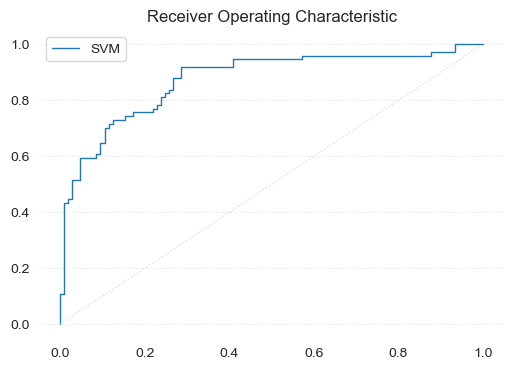

In [113]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_svm, tpr_svm, label = 'SVM', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### K neighbors classifier

In [114]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [115]:
knn_pred = knn.predict(X_test)
print(f'Accuracy of KNN Model : {accuracy_score(y_test, knn_pred) : .4f}')

Accuracy of KNN Model :  0.7318


In [117]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       105
           1       0.73      0.55      0.63        74

    accuracy                           0.73       179
   macro avg       0.73      0.71      0.71       179
weighted avg       0.73      0.73      0.72       179



In [119]:
confusion_matrix(y_test, knn_pred)

array([[90, 15],
       [33, 41]])

In [120]:
knn_prob = knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thres = roc_curve(y_test, knn_prob)

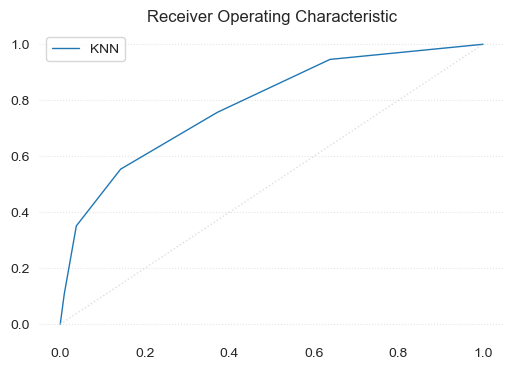

In [121]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_knn, tpr_knn, label = 'KNN', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Naive Bayes

In [122]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [123]:
naive_bayes_pred = naive_bayes.predict(X_test)
print(f'Accuracy of Support Vector Machine : {accuracy_score(y_test, naive_bayes_pred) : .4f}')

Accuracy of Support Vector Machine :  0.7877


In [124]:
print(classification_report(y_test, naive_bayes_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       105
           1       0.74      0.74      0.74        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [125]:
confusion_matrix(y_test, naive_bayes_pred)

array([[86, 19],
       [19, 55]])

In [129]:
gnb_prob = naive_bayes.predict_proba(X_test)[:, 1]
fpr_gnb, tpr_gnb, thres = roc_curve(y_test, gnb_prob)

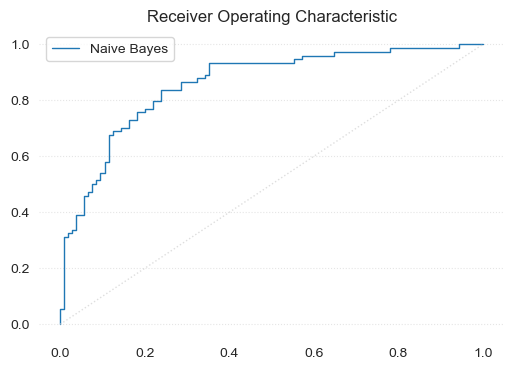

In [130]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_gnb, tpr_gnb, label = 'Naive Bayes', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Decision Tree

In [131]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 5,
    random_state = 42
)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [132]:
tree_pred = decision_tree.predict(X_test)
print(f'Accuracy of Support Vector Machine : {accuracy_score(y_test, tree_pred) : .4f}')

Accuracy of Support Vector Machine :  0.8156


In [133]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



In [134]:
tree_prob = decision_tree.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, thres = roc_curve(y_test, tree_prob)

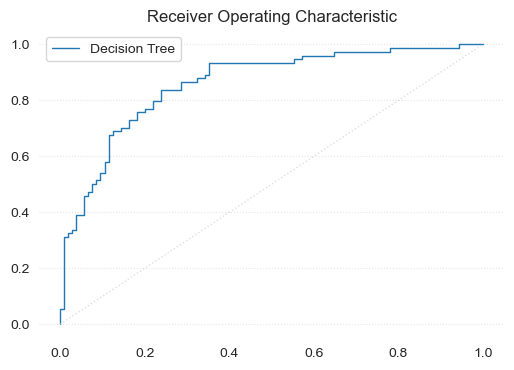

In [135]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_gnb, tpr_gnb, label = 'Decision Tree', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    n_estimators = 1000,
    criterion = 'entropy'
)
random_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000)

In [147]:
random_forest_pred = random_forest.predict(X_test)
print(f'Accuracy of Random Forest : {accuracy_score(y_test, random_forest_pred) : .4f}')

Accuracy of Random Forest :  0.8212


In [148]:
print(classification_report(y_test, random_forest_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [149]:
confusion_matrix(y_test, random_forest_pred)

array([[91, 14],
       [18, 56]])

In [150]:
random_forest_prob = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thres = roc_curve(y_test, random_forest_prob)

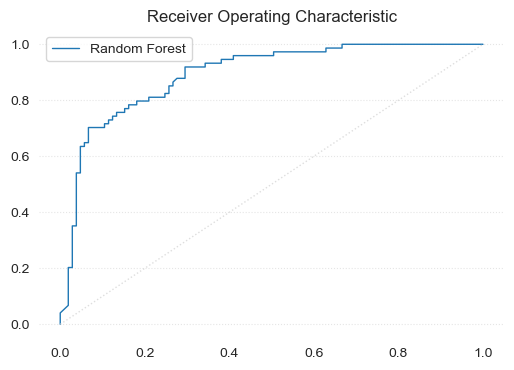

In [151]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_rf, tpr_rf, label = 'Random Forest', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Bagging Classifier

In [159]:
from sklearn.ensemble import BaggingClassifier

base = RandomForestClassifier(
    n_estimators = 1,
    max_depth = 10,
    random_state = 42,
    criterion = 'entropy',
    min_samples_split = 2
)

bagging = BaggingClassifier(
    n_estimators = 1000,
    estimator = base,
    random_state = 42
)

bagging.fit(X_train, y_train)

BaggingClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                   max_depth=10, n_estimators=1,
                                                   random_state=42),
                  n_estimators=1000, random_state=42)

In [160]:
bagging_pred = bagging.predict(X_test)
print(f'Accuracy of Bagging Classifier: {accuracy_score(y_test, bagging_pred) : .4f}')

Accuracy of Bagging Classifier:  0.8324


In [161]:
print(classification_report(y_test, bagging_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       105
           1       0.83      0.74      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [162]:
confusion_matrix(y_test, bagging_pred)

array([[94, 11],
       [19, 55]])

In [163]:
bagging_prob = bagging.predict_proba(X_test)[:, 1]
fpr_bagging, tpr_bagging, thres = roc_curve(y_test, bagging_prob)

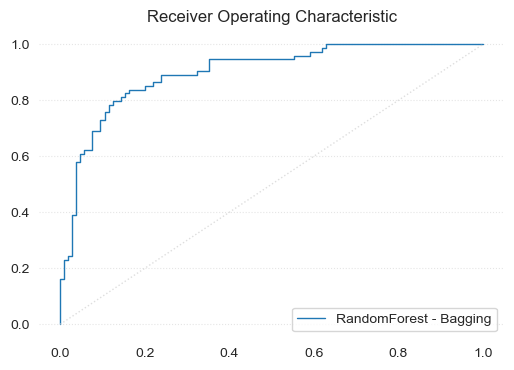

In [164]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_bagging, tpr_bagging, label = 'RandomForest - Bagging', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Stacking Classifier

In [170]:
from sklearn.ensemble import StackingClassifier

stack_base = [
    (
        'random_forest', RandomForestClassifier(
            n_estimators = 1000,
            random_state = 42,
            criterion = 'entropy',
            max_depth = 5,
            max_samples = 3,
            min_samples_split = 2
        )
    ), (
        'support_vector_machine', SVC(
            kernel = 'rbf',
            C = 1.0,
            random_state = 42
        )
    ), (
        'KNN', KNeighborsClassifier(
            n_neighbors = 5
        )
    ), (
        'naive_bayes', GaussianNB()
    )
]

meta_model = RandomForestClassifier(
    random_state = 42,
    n_estimators = 1000,
    criterion = 'entropy',
    max_depth = 5
)

stacking = StackingClassifier(
    estimators = stack_base,
    final_estimator = meta_model,
    cv = 5
)

stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=5,
                                                       max_samples=3,
                                                       n_estimators=1000,
                                                       random_state=42)),
                               ('support_vector_machine', SVC(random_state=42)),
                               ('KNN', KNeighborsClassifier()),
                               ('naive_bayes', GaussianNB())],
                   final_estimator=RandomForestClassifier(criterion='entropy',
                                                          max_depth=5,
                                                          n_estimators=1000,
                                                          random_state=42))

In [171]:
stack_pred = stacking.predict(X_test)
print(f'Accuracy of Stacking Classifier : {accuracy_score(y_test, stack_pred) : .4f}')

Accuracy of Stacking Classifier :  0.7989


In [172]:
print(classification_report(y_test, stack_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [173]:
confusion_matrix(y_test, stack_pred)

array([[89, 16],
       [20, 54]])

In [174]:
stack_prob = stacking.predict_proba(X_test)[:, 1]
fpr_stack, tpr_stack, thres = roc_curve(y_test, stack_prob)

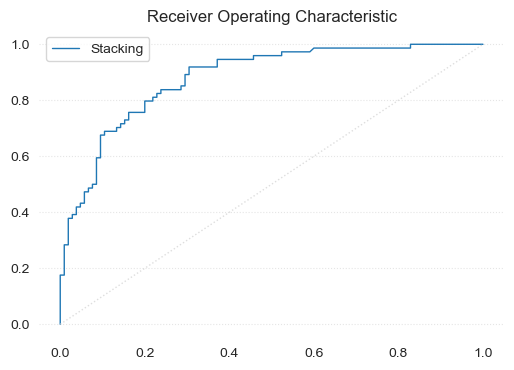

In [175]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_stack, tpr_stack, label = 'Stacking', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### AdaBoost

In [176]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(
    n_estimators = 1000,
    random_state = 42,
    learning_rate = 0.01,
    algorithm = 'SAMME.R'
)
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01, n_estimators=1000, random_state=42)

In [177]:
ada_pred = ada_boost.predict(X_test)
print(f'Accuracy of AdaBoost Classifier: {accuracy_score(y_test, ada_pred) : .4f}')

Accuracy of AdaBoost Classifier:  0.8101


In [178]:
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [179]:
confusion_matrix(y_test, ada_pred)

array([[91, 14],
       [20, 54]])

In [180]:
ada_prob = ada_boost.predict_proba(X_test)[:, 1]
fpr_ada, tpr_ada, thres = roc_curve(y_test, ada_prob)

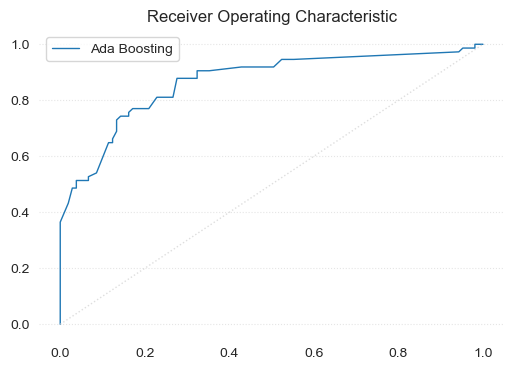

In [181]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_ada, tpr_ada, label = 'Ada Boosting', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

#### Gradient Boosting

In [185]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost = GradientBoostingClassifier(
    loss = 'log_loss',
    learning_rate = 0.01,
    n_estimators = 1000,
    criterion = 'squared_error',
    max_depth = 5,
    random_state = 42
)
gradient_boost.fit(X_train, y_train)

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.01,
                           max_depth=5, n_estimators=1000, random_state=42)

In [186]:
gradient_pred = gradient_boost.predict(X_test)
print(f'Accuracy of Gradient Boosting Classifier: {accuracy_score(y_test, gradient_pred) : .4f}')

Accuracy of Gradient Boosting Classifier:  0.8101


In [188]:
print(classification_report(y_test, gradient_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [189]:
confusion_matrix(y_test, gradient_pred)

array([[91, 14],
       [20, 54]])

In [190]:
gradient_prob = gradient_boost.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, thres = roc_curve(y_test, gradient_prob)

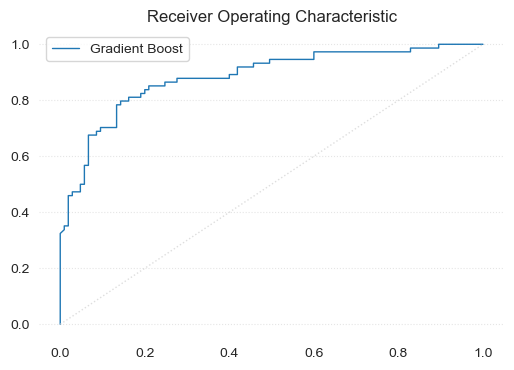

In [191]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_gb, tpr_gb, label = 'Gradient Boost', lw = 1)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()

### Compatison

In [198]:
result = {
    'Logit' : accuracy_score(y_test, logit_pred),
    'Probit' : accuracy_score(y_test, probit_pred),
    'SVM' : accuracy_score(y_test, svm_pred),
    'KNN' : accuracy_score(y_test, knn_pred),
    'Naive Bayes' : accuracy_score(y_test, naive_bayes_pred),
    'Dicision Tree' : accuracy_score(y_test, tree_pred),
    'Random Forest' : accuracy_score(y_test, random_forest_pred),
    'Bagging' : accuracy_score(y_test, bagging_pred),
    'Stacking' : accuracy_score(y_test, stack_pred),
    'Ada Boosting' : accuracy_score(y_test, ada_pred),
    'Gradient Boosting' : accuracy_score(y_test, gradient_pred)
}

result = pd.Series(result, name = 'accuracy')

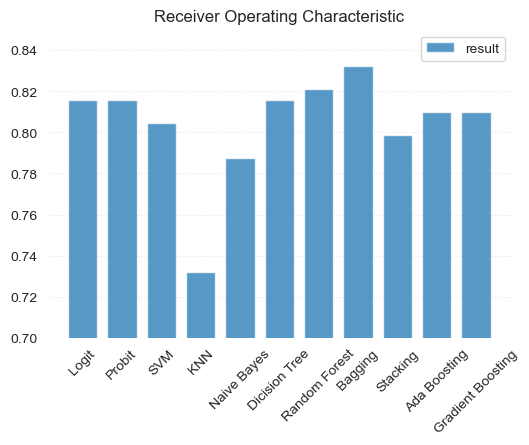

In [207]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.bar(result.index, result, label = 'result', width = 0.75, alpha = 0.75)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.ylim([0.7, 0.85])
plt.xticks(rotation = 45)
plt.title('Receiver Operating Characteristic')
plt.show()

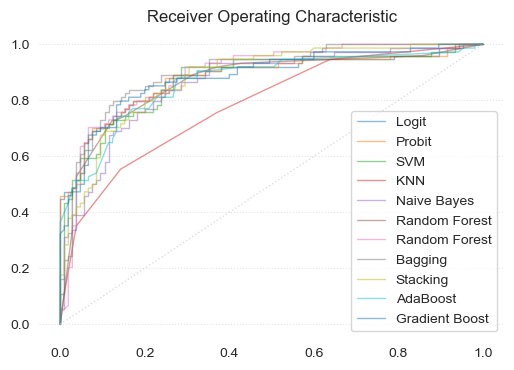

In [208]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(fpr_logit, tpr_logit, label = 'Logit', lw = 1, alpha = 0.5)
ax.plot(fpr_probit, tpr_probit, label = 'Probit', lw = 1, alpha = 0.5)
ax.plot(fpr_svm, tpr_svm, label = 'SVM', lw = 1, alpha = 0.5)
ax.plot(fpr_knn, tpr_knn, label = 'KNN', lw = 1, alpha = 0.5)
ax.plot(fpr_gnb, tpr_gnb, label = 'Naive Bayes', lw = 1, alpha = 0.5)
ax.plot(fpr_tree, tpr_tree, label = 'Random Forest', lw = 1, alpha = 0.5)
ax.plot(fpr_rf, tpr_rf, label = 'Random Forest', lw = 1, alpha = 0.5)
ax.plot(fpr_bagging, tpr_bagging, label = 'Bagging', lw = 1, alpha = 0.5)
ax.plot(fpr_stack, tpr_stack, label = 'Stacking', lw = 1, alpha = 0.5)
ax.plot(fpr_ada, tpr_ada, label = 'AdaBoost', lw = 1, alpha = 0.5)
ax.plot(fpr_gb, tpr_gb, label = 'Gradient Boost', lw = 1, alpha = 0.5)
ax.plot(
    [0, 1], 
    [0, 1], 
    ls = ':', 
    color = 'lightgray', 
    alpha = 0.75, 
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()
plt.title('Receiver Operating Characteristic')
plt.show()